<a href="https://colab.research.google.com/github/sulaimanbehzad/Classifying-Images/blob/main/Image_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifiers
The purpose of this project is to train two classifiers:
1. Captions classifier
2. Image classifier

In [26]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

# Let's check the version of TensorFlow in Colab
print("TensorFlow's version: ", tf.__version__)

TensorFlow's version:  2.4.1


## Part 1: Captions Classifier

Reading the txt files and formatting them into a dataframe

In [5]:
# function for reading text files into a pandas dataframe
def read_data_into_df(filespath):
  levels = 0
  for roots, dirnames, filenames in os.walk(filespath):
    if levels == 0:
      df = pd.DataFrame(columns=dirnames)
    txt_list = []
    for fn in filenames:
      txtfile_full_path = os.path.join(roots, fn)
      # print(txtfile_full_path)
      # temp=pd.read_csv(txtfile_full_path,sep="\\n", header=None, error_bad_lines=False)
      # print('shape of temp: ', temp.shape)
      # txt_list.append(temp.values)
      # -------------------- another approach to read txt files
      with open(txtfile_full_path) as f:
        txt_list.append(f.read())
    root = os.path.split(roots) 
    root = root[1]
    # print(root)
    if levels != 0:
      df[root] = txt_list
    levels+=1
  return df


In [6]:
path_train_sentences = r'/content/drive/MyDrive/dataset/train/sentences'   
path_test_sentences =  r'/content/drive/MyDrive/dataset/test/sentences'   
train = read_data_into_df(path_train_sentences)
test = read_data_into_df(path_test_sentences)

### Dataframe inspection, evaluation and preprocessing


In [7]:
train.head()

,bird,aeroplane,bicycle,car,chair,dog,cat,bus,diningtable,cow,boat,motorbike,horse,pottedplant,tvmonitor,person,sheep,train,sofa
0,a lifeguard tower and a yellow lifeguard truck...,A boat is in the water and a small airplane is...,A man knees on the ground while talking on his...,"A clean, shiny black tire in the rear of a tru...",A black cat looking at image in a mirror.\nA b...,"A small white dog standing, wearing some dog-c...",A ginger cat laying on black plastic.\nAn oran...,A bus drives down a busy road.\na bus driving ...,A close-up of a head table set with gray napki...,A close-up of a cream animal with big ears and...,A cruise ship docked at a coast.\nA docked blu...,A close up of the front end of a purple and wh...,A jockey races on the number 6 gray horse.\na ...,An indoor plant in a yellow pot by a window.\n...,A home office with three computer monitors and...,A man driving an orange scooter through a tunn...,A adult and two young sheep in a field\nAdult ...,A small train stopped on the tracks in a park....,Teenagers hanging out in their room.\nTwo guys...
1,A close up of a seagull with others in the bac...,An airplane sitting on the tarmac at an airpor...,A bicycle racer in front of a car which has tw...,A BOAC Boeing 747 sitting on the airport tarma...,A smiling woman with a beer sitting outside wi...,A brown dog curled up in its bed.\nA dog layin...,A cat is looking out the window.\nA cat lookin...,A double decker bus on a city street.\nA red d...,A naturally stained wooden table with four cha...,Several cows grazing on grass in field.\nThree...,A group of river barges with trees in the back...,A helmet wearing motorcycle stuntman performs ...,A foal frolicking in a grassy field.\nA pony r...,A black and white cat gets into a basket of ya...,A television and entertainment center.\nA wide...,A man is smiling in a garden\nA man kneeling d...,A large field containing a group of sheep with...,A colorful train\nAn old American steam engine...,A woman is lying across the laps of two men si...
2,An American Eagle standing on a post with its ...,A small plane parked at an airfield with a clo...,Cyclists crossing a metal bridge.\nSeveral peo...,A large green bus on the street.\nA large gree...,A desk and chair are illuminated and near a la...,A close up picture of a Saint Bernard.\nA larg...,A black stripped cat\nA striped cat laying dow...,A Continental air liner parked at an airport.\...,A group of elderly people pose around a dining...,a girl with glasses and a brown cow\na woman p...,Airplanes flying in formation over boats in a ...,A family preparing to ride dirt bikes.\nA man ...,"a bald man smiling with a black, white-haired ...",A line outside of a bookstore on a street.\nA ...,A man pressing a button on a television.\nA ma...,A woman in a t-shirt chops mushrooms.\nA woman...,A domestic animal stands in a pen.\nA sheep st...,An indoor train depot with trains on both side...,A dining table in front of a window with two s...
3,A blue bird standing on a lawn.\nA blue jay st...,a larger plane in flying above a smaller plane...,A person rides a bicycle on concrete.\nA woman...,A white limo is parked on the side of a street...,An smiling asian child sits beside a young wom...,an old black woman wearing a turban and a head...,A brown cat sits by a window.\nA graceful cat ...,A park garden in front of red trolleys and a l...,Several people holding glasses of wine at tabl...,Two black ox with goods on their back.\nTwo la...,a boat with two people on blue water in front ...,A heavy traffic scene with many cars and motor...,Two brown horses in a pasture.\nTwo brown hors...,Two blue macaws sit on a perch in a lush green...,A boy looking at a computer screen.\nA boy loo...,A close-up of two women posing with their thum...,A black sheep and a white sheep stand on grass...,A long train is on train tracks.\nA yellow fre...,a living room with a birdcage in the left corn...
4,a close up head of an ostrich\nA close up of a...,A pas

In [8]:
test.head()

,aeroplane,dog,bus,boat,cow,diningtable,cat,bicycle,bird,chair,car,pottedplant,motorbike,train,person,tvmonitor,sofa,sheep,horse
0,A large passenger plane on a landing strip.\nA...,A black and white dog sniffing at a closed doo...,"A view of a street filled with vehicles, peopl...",A sailboat at sea\nA sailboat with a yellow sa...,a father is introducing his daughter to a cow ...,A bronze statue of a buddy holding a candle si...,A cat sitting on sand looking up at the camera...,Two African men carry a tied up animal in the ...,A hand holding bird seed and a small bird.\nA ...,A group of people sitting around a table on a ...,A boy sits on a horse near a group of people a...,A living with pink walls.\nA room with pink wa...,African man on blue bike posing with 2 friends...,an old wooden train heading toward an old stat...,A guy wearing a cap backwards and standing bet...,A close-up of a computer sitting on a desk wit...,A dark brown dog on a blue loveseat and a ligh...,A large ram at the top of a hill.\nAnimal stan...,Horse outfitted with riding gear.\nThere are t...
1,A blue airplane beside the blue water.\nA blue...,A brown dog lying on the grass.\nA brown dog s...,A red double decker bus is picking up more pas...,A fisherman in a small boat in the middle of a...,a black and white photo of a cow under a tree\...,A group of friends gathered in a restaurant ea...,A cat looks away while laying down in an offic...,Bikers lean into a turn during a race.\nRacing...,A humming bird feeding\nA hummingbird on a bra...,"A bulldog is sitting on a yellow chair, which ...",A blonde in a polka-dot bikini poses in front ...,A potted plant with only two leaves sprouted.\...,A BMW motorcycle parked between two cars.\nA r...,A passenger train waiting in a station.\nA red...,A large white bus parked next to a blue truck ...,A Mickey Mouse figurine is sitting next to a t...,A black and white photo of a love seat.\nA bla...,A sheep with a tree in the foreground.\nSheep ...,A boy and his mom feeding ponies through the f...
2,A gray jet on a tarmac.\nAn airplane being ins...,An elderly woman poses beside a small child dr...,A double-decker bus passes a row of flags.\nA ...,An ocean liner at sea.\nA picture of a large s...,A black and white cow looking through the fenc...,Two people are sitting in a small antique shop...,A brown cat wearing a shiny collar with a blue...,A child holding large bags stands next to a ta...,A bird standing on top of a wooden fencepost.\...,A boy and a girl smile while standing by some ...,An Esso gas station with trees in the backgrou...,Herbs grow in terra cotta plants on a balcony....,A black and white photo of a motorcycle laying...,A black train engine is facing me on the track...,a man on a dirt bike jumping very high.\nA man...,Several televisions are on the floor and stack...,A woman and elderly woman sitting together pos...,Distant view of two lambs perched on top of a ...,A man in a black uniform on a white horse.\nA ...
3,An airplane facing the camera.\nA plane is sit...,A brindle dog lying on a cushion next to a pla...,A large yellow bus is parked next to a buildin...,Boats anchor off a short distance from the sho...,A black and white horned cow standing in a fie...,A man holding a baby and a woman eating at a t...,A kitten looking at the camera.\nA kitten lyin...,A main holds two bikes near a beach.\nA young ...,A white bird flying up onto a tree.\nA white b...,An empty hallway leading into a room with brow...,A two story building on a street with a white ...,A courtyard with a small pagoda in the center....,A motorcycle parked next to a car.\nA silver a...,A moving train in a suburban area\nA train is ...,A woman in a black bikini top and jeans.\nA wo...,A computer desk displays elvis memorabilia.\nA...,a blue couch with Power Puff Girls cushions wi...,"A close-up of a lamb with its ear tagged, stan...",A man in a tux on a white horse.\nA man wearin...
4,Airplane on runway in front of buildings.\nAn ...,a dog

The dataframes don't have any null values so we are good to go on that aspect  
What remains is to add tags to the captions of each type

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   bird         28 non-null     object
 1   aeroplane    28 non-null     object
 2   bicycle      28 non-null     object
 3   car          28 non-null     object
 4   chair        28 non-null     object
 5   dog          28 non-null     object
 6   cat          28 non-null     object
 7   bus          28 non-null     object
 8   diningtable  28 non-null     object
 9   cow          28 non-null     object
 10  boat         28 non-null     object
 11  motorbike    28 non-null     object
 12  horse        28 non-null     object
 13  pottedplant  28 non-null     object
 14  tvmonitor    28 non-null     object
 15  person       28 non-null     object
 16  sheep        28 non-null     object
 17  train        28 non-null     object
 18  sofa         28 non-null     object
dtypes: object(19)
memory usage: 4.3

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   aeroplane    20 non-null     object
 1   dog          20 non-null     object
 2   bus          20 non-null     object
 3   boat         20 non-null     object
 4   cow          20 non-null     object
 5   diningtable  20 non-null     object
 6   cat          20 non-null     object
 7   bicycle      20 non-null     object
 8   bird         20 non-null     object
 9   chair        20 non-null     object
 10  car          20 non-null     object
 11  pottedplant  20 non-null     object
 12  motorbike    20 non-null     object
 13  train        20 non-null     object
 14  person       20 non-null     object
 15  tvmonitor    20 non-null     object
 16  sofa         20 non-null     object
 17  sheep        20 non-null     object
 18  horse        20 non-null     object
dtypes: object(19)
memory usage: 3.1

In [11]:
for i in train['chair']:
  print(i)

A black cat looking at image in a mirror.
A black cat sitting on a pink chair, next to a table holding a mirror and a plant.
A black cat sitting on a pink folding chair staring into a mirror sitting on a table next to a plant.
Black cat with pink collar staring into small mirror.
The cat seems to like her reflection in the mirror.

A smiling woman with a beer sitting outside with another smiling woman.
Two seated women laughing with one holding a bottle.
two women laugh together one is driving beer
Two women sitting down laughing.
Two women sitting outside laughing.

A desk and chair are illuminated and near a laundry closet.
A room with tan walls and a washer and dryer.
A small desk with chair near a laundry closet.
Small wood desk with papers spread on it.
There is a small desk and chair in front of the laundry room.

An smiling asian child sits beside a young women near a blue mosaic table.
Asian mother and daughter seated at a dinner table.
A small girl and a woman seated at a rest

In [12]:
def make_tabular_df(df):
  tags = df.columns
  df_transpose = df.transpose(copy=False)
  output = pd.DataFrame(columns=['captions',  'tags'])
  for index, col in df_transpose.iteritems():
    new = []
    for item in col:
      new.append(item)
    df=pd.DataFrame({"captions": new, "tags": tags})
    output=output.append(df)
  return output


In [13]:
X_train = make_tabular_df(train)
X_train.head()

,captions,tags
0,a lifeguard tower and a yellow lifeguard truck...,bird
1,A boat is in the water and a small airplane is...,aeroplane
2,A man knees on the ground while talking on his...,bicycle
3,"A clean, shiny black tire in the rear of a tru...",car
4,A black cat looking at image in a mirror.\nA b...,chair


In [14]:
X_test = make_tabular_df(test)
X_test.head()

,captions,tags
0,A large passenger plane on a landing strip.\nA...,aeroplane
1,A black and white dog sniffing at a closed doo...,dog
2,"A view of a street filled with vehicles, peopl...",bus
3,A sailboat at sea\nA sailboat with a yellow sa...,boat
4,a father is introducing his daughter to a cow ...,cow


We obtained the dataframes ready to go to next phase


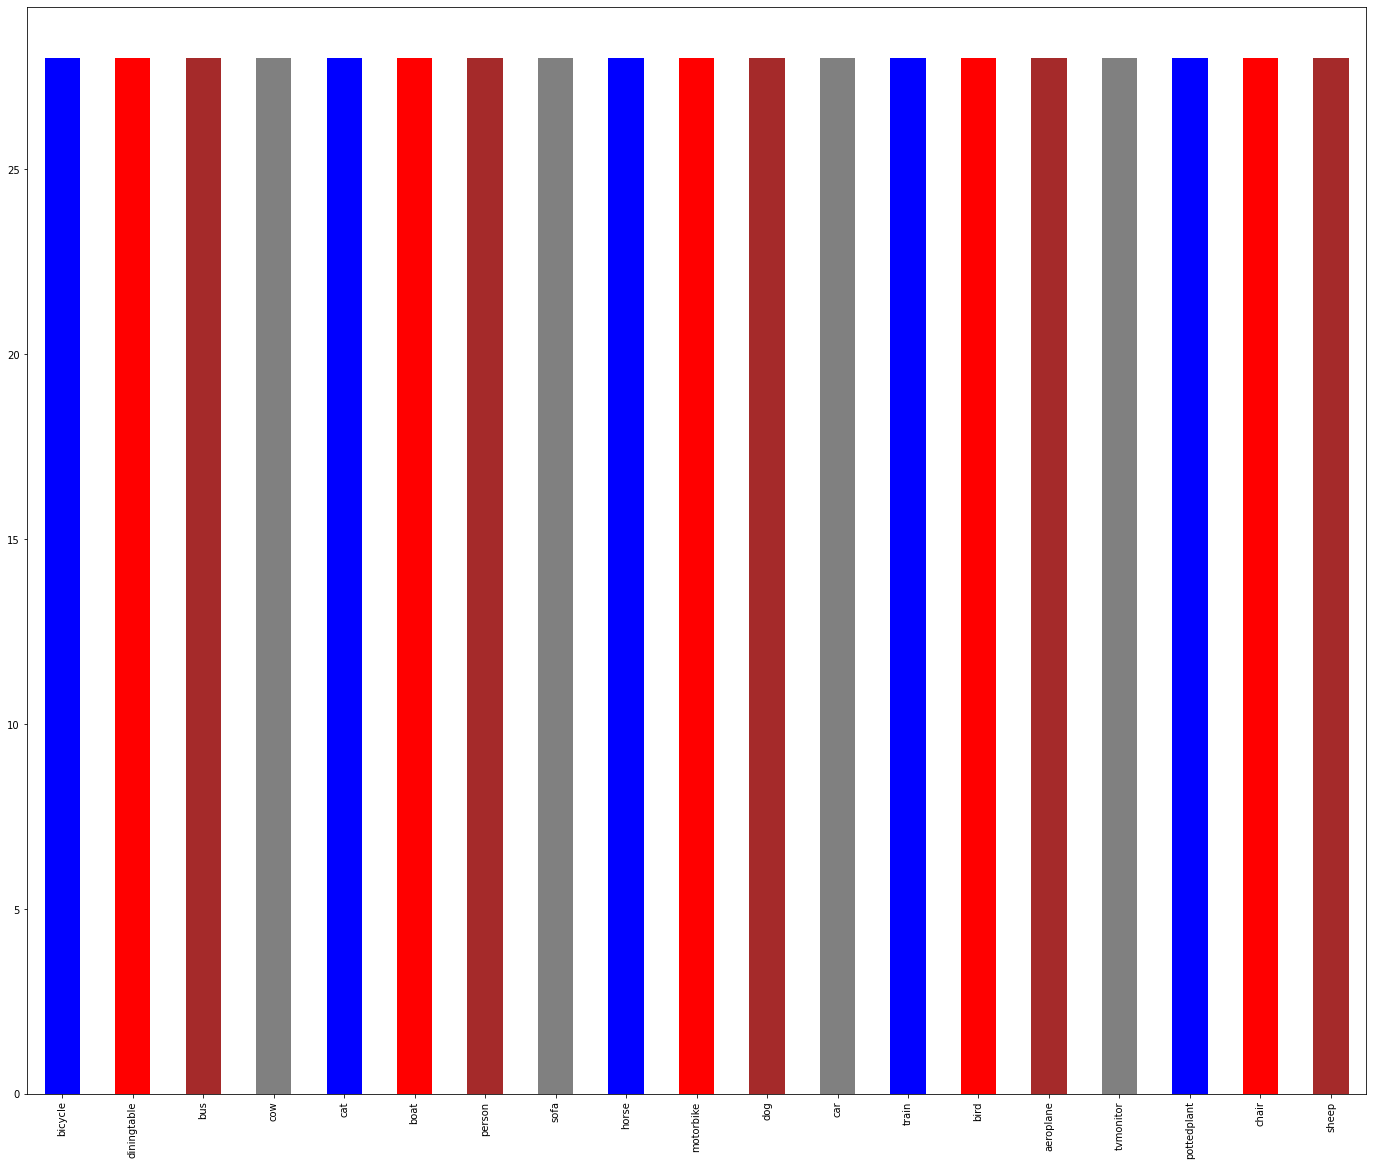

In [67]:
plt.figure(figsize=(24,20))
X_train.tags.value_counts().plot(kind='bar', color=['Blue', 'Red', 'Brown', 'Gray']);

We can confirm visually that our dataset is balanced

## Bag-Of-Words (BOW) with Keras

In [28]:
print(f"train size: {len(X_train)}")
print(f"test size: {len(X_test)}")

train size: 532
test size: 380


In [29]:
max_words = 1500
tokenizer = text.Tokenizer(num_words=max_words, char_level=False)

In [31]:
tokenizer.fit_on_texts(X_train['captions']) 
x_train = tokenizer.texts_to_matrix(X_train['captions'])
x_test = tokenizer.texts_to_matrix(X_test['captions'])
x_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [32]:
x_test

array([[0., 1., 1., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [34]:
print(f'shape of new x_train is: {x_train.shape}')
print(f'shape of new x_test is: {x_test.shape}')

shape of new x_train is: (532, 1500)
shape of new x_test is: (380, 1500)


in both encoder and tokenizer we only fit on train for consistency

In [35]:
le = LabelEncoder()
le.fit(X_train['tags'])
y_train = le.transform(X_train['tags'])
y_test = le.transform(X_test['tags'])

In [36]:
print(f'shape of new y_train is: {y_train.shape}')
print(f'shape of new y_test is: {y_test.shape}')

shape of new y_train is: (532,)
shape of new y_test is: (380,)


Convert the enoded y_train and y_test to one-hot representation

In [38]:
num_tags = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_tags)
y_test = utils.to_categorical(y_test, num_tags)
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [39]:
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [40]:
print(f'shape of new x_train is: {x_train.shape}')
print(f'shape of new x_test is: {x_test.shape}')
print(f'shape of new y_train is: {y_train.shape}')
print(f'shape of new y_test is: {y_test.shape}')

shape of new x_train is: (532, 1500)
shape of new x_test is: (380, 1500)
shape of new y_train is: (532, 19)
shape of new y_test is: (380, 19)


Let's set our hyperparameters  
we will adjust these later to, if possible, reach higher accuracy

In [57]:
batch_size = 16
epochs = 3

Buliding the model

In [46]:
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_tags))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

we have the model, train and test data prepared  
so let's train the model

In [58]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                    verbose=1, validation_split=0.1)

Epoch 1/3
30/30 [==============================] - 0s 8ms/step - loss: 0.0532 - accuracy: 1.0000 - val_loss: 0.9621 - val_accuracy: 0.7222
Epoch 2/3
30/30 [==============================] - 0s 6ms/step - loss: 0.0380 - accuracy: 1.0000 - val_loss: 0.9707 - val_accuracy: 0.7222
Epoch 3/3
30/30 [==============================] - 0s 7ms/step - loss: 0.0289 - accuracy: 1.0000 - val_loss: 0.9643 - val_accuracy: 0.7037


In [60]:
score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print(f'Test score:{score[0]}')
print(f'Test accuracy:{score[1]}')

24/24 [==============================] - 0s 2ms/step - loss: 0.9511 - accuracy: 0.7605
Test score:0.9510786533355713
Test accuracy:0.7605262994766235


In [62]:
txt_lbls = le.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = txt_lbls[np.argmax(prediction)]
    print(X_test['captions'].iloc[i][:50], "...")
    print('Actual label:' + X_test['tags'].iloc[i])
    print("Predicted label: " + predicted_label + "\n")

A large passenger plane on a landing strip.
A Luft ...
Actual label:aeroplane
Predicted label: aeroplane

A black and white dog sniffing at a closed door.
A ...
Actual label:dog
Predicted label: dog

A view of a street filled with vehicles, people, a ...
Actual label:bus
Predicted label: bus

A sailboat at sea
A sailboat with a yellow sail in ...
Actual label:boat
Predicted label: boat

a father is introducing his daughter to a cow on a ...
Actual label:cow
Predicted label: cow

A bronze statue of a buddy holding a candle sittin ...
Actual label:diningtable
Predicted label: chair

A cat sitting on sand looking up at the camera
A g ...
Actual label:cat
Predicted label: cat

Two African men carry a tied up animal in the bask ...
Actual label:bicycle
Predicted label: cow

A hand holding bird seed and a small bird.
A perso ...
Actual label:bird
Predicted label: bird

A group of people sitting around a table on a porc ...
Actual label:chair
Predicted label: diningtable



In [70]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [65]:
y_sm = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_sm)):
    probs = y_sm[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

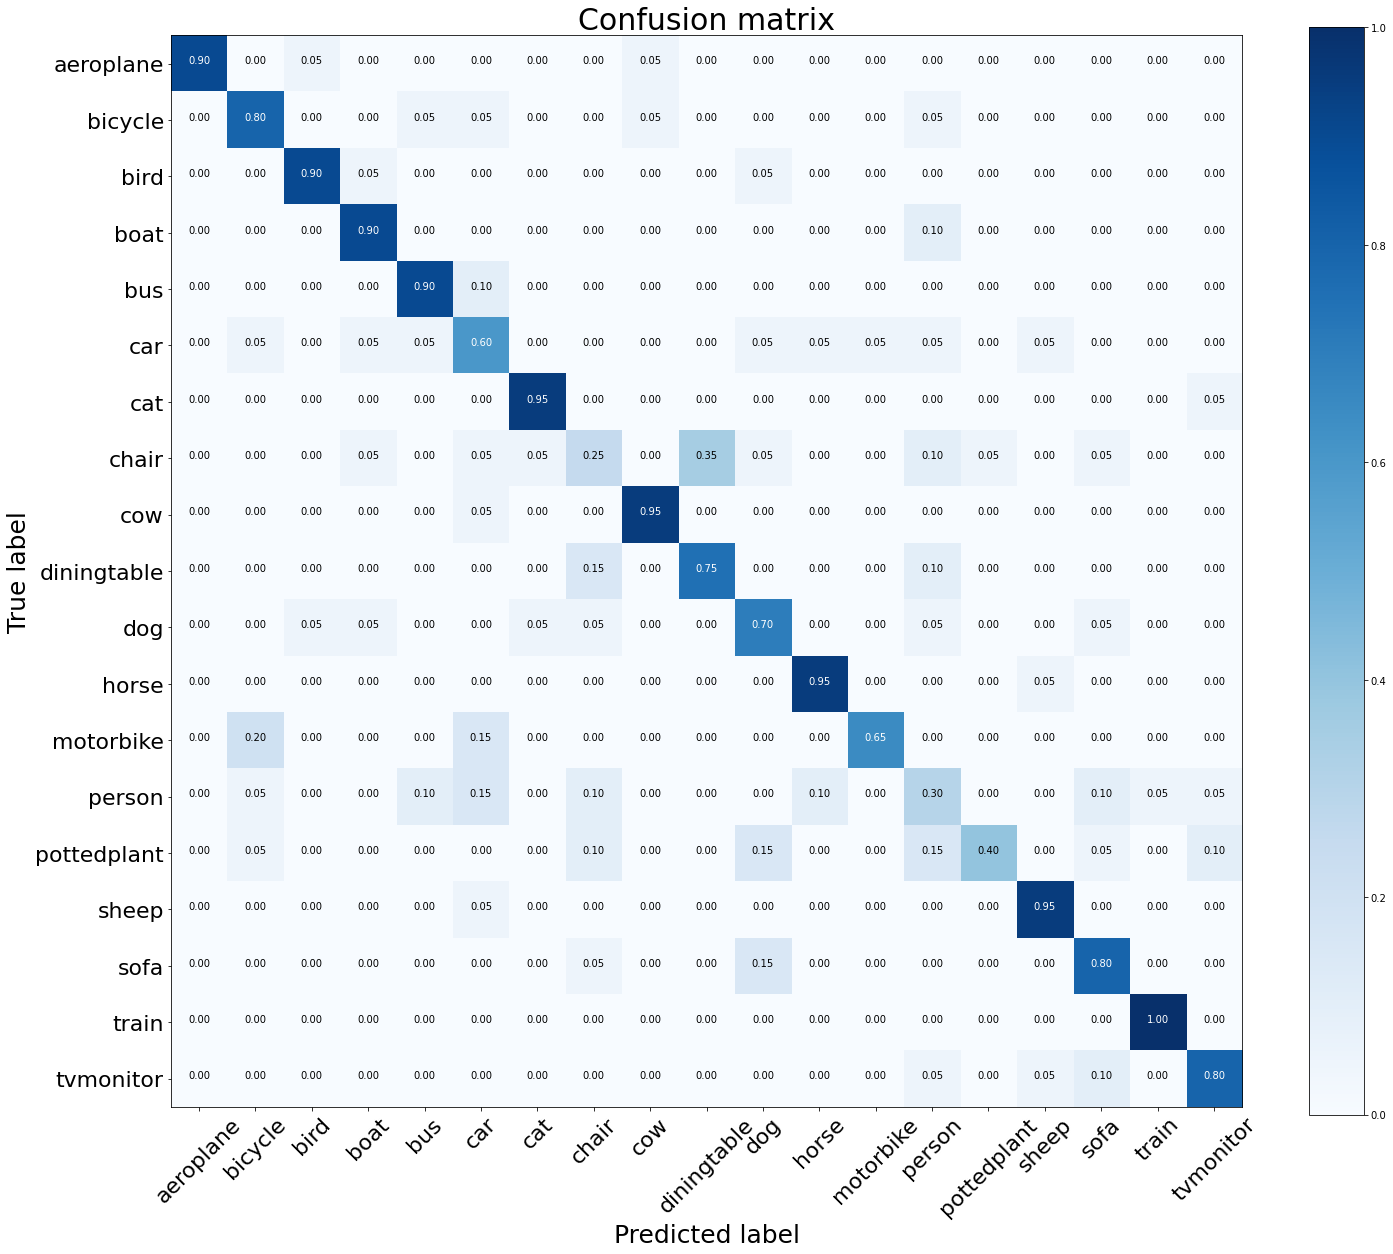

In [71]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=txt_lbls, title="Confusion matrix")
plt.show()